# Constructions for a bivariate beta distribution

**Authors:** Ingram Olkin a , Thomas A. Trikalinos b,

In this paper, the authors build a possible bivariate form for beta distribution such that its marginal is beta distribution. Other aproaches from other researchers are cited. This construction allows the correlation between the variables range from -1 to 1. 

In [1]:
%matplotlib inline

import numpy as np
from scipy.special import gamma
from scipy.integrate import quad

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from time import time

The construction can be summarized as follows: 

1. Let $U_{11}, U_{10}, U_{01}$ have the Dirichlet distribution with parameter $\alpha_{ij} \ge 0$, and $\alpha  = (\alpha_{11}, \alpha_{10}, \alpha_{01} , \alpha_{00})$.

2. Define $X = U_{11} + U_{10}, Y = U_{11} + U_{01}$.

3. The joint ditribution of $(X,Y)$ with domain $\Omega = \{u_{11} : \max(0, x + y - 1) < u_{11} < \min(x, y)\}$ is bivariate beta. 

Remarks: 

- Non closed form; 
- Density symmetric in $(x, \alpha_{10})$ and $(y, \alpha_{01})$. 

In [2]:
alpha = np.array([4,2,2,2])
# Generating Dirichlet
U = np.random.dirichlet(alpha, size = 10000)
# Calculating X and Y
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]

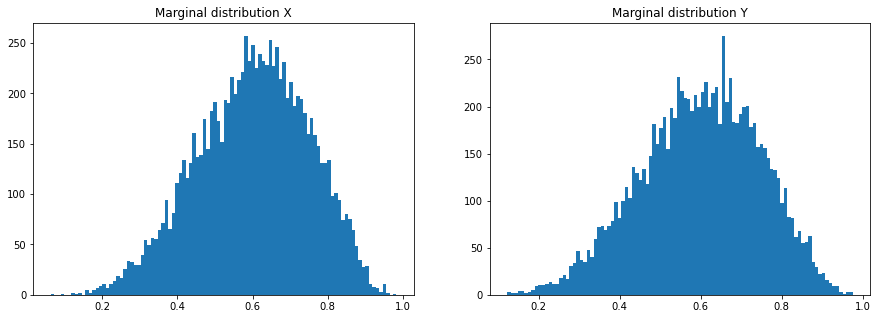

In [3]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].hist(X, 100)
ax[1].hist(Y, 100)
ax[0].set_title('Marginal distribution X')
ax[1].set_title('Marginal distribution Y')
plt.show()

In [4]:
np.corrcoef(X,Y)

array([[1.        , 0.16402417],
       [0.16402417, 1.        ]])

We now write the function as described in the article. 

In [225]:
gen_beta = lambda alpha: gamma(alpha).prod()/gamma(alpha.sum())

def f_u_exp_log(u, x, y, alpha):
    
    log_fun  = (alpha[0]-1)*np.log(u)
    log_fun += (alpha[1]-1)*np.log(x-u)
    log_fun += (alpha[2]-1)*np.log(y-u)
    log_fun += (alpha[3]-1)*np.log1p(-x-y+u)
    
    return np.exp(log_fun)

def f_u(u, x, y, alpha): 
    
    if (u == 0) or (u == x) or (u == y) or (u == x+y-1): 
        return 0
    
    fun  = u**(alpha[0]-1)
    fun *= (x-u)**(alpha[1]-1)
    fun *= (y-u)**(alpha[2]-1)
    fun *= (1-x-y+u)**(alpha[3]-1)
    
    return fun


def bivariate_beta_pdf(x,y,alpha, func): 
    
    if x == 0 or y == 0: return 0
    if x == 1 or y == 1: return 0
    
    c = gen_beta(alpha)
    
    lb = max(0,x+y-1)
    ub = min(x,y)
            
    return quad(func, lb, ub, args = (x,y,alpha))/c

In [271]:
alphas = np.array([[1,1,1,1], 
                   [.8,.8,.8,.8],
                   [2,4,2,2],
                   [2,2,4,2],
                   [2,2,2,4],
                   [4,2,4,1],
                   [2,2,2,.5],
                   [1,1,1,0.5],
                   [10,1,1,10]
                 ])

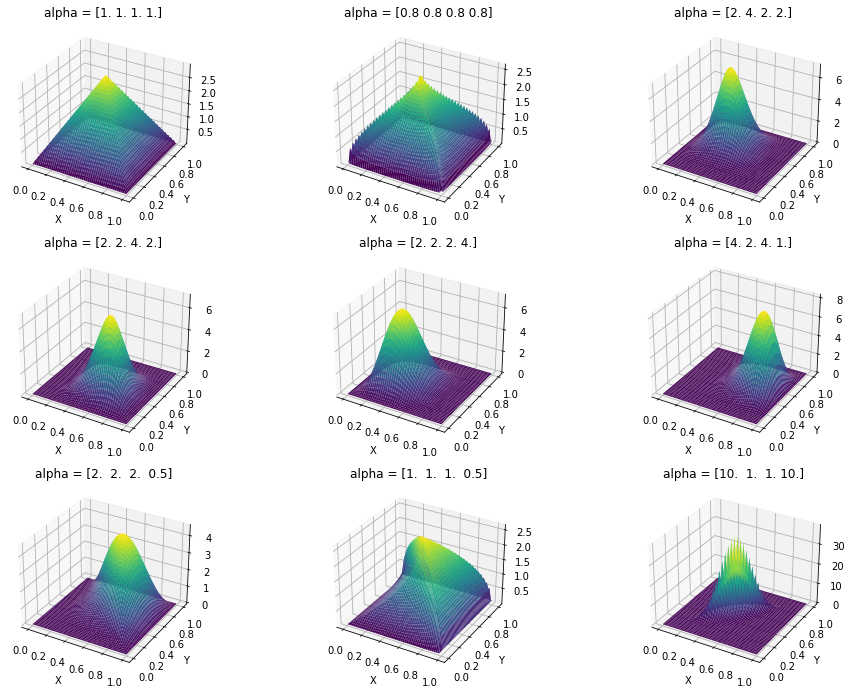

In [272]:
x_values = y_values = np.linspace(0.001, 0.999, 50)
X, Y = np.meshgrid(x_values,y_values)

fig = plt.figure(figsize = (16, 12))

Z = np.zeros_like(X)

for k, alpha in enumerate(alphas): 

    for i,x in enumerate(x_values): 
        for j,y in enumerate(y_values): 
            Z[i,j] = bivariate_beta_pdf(x, y, alpha, f_u)[0]
            
    ax = fig.add_subplot(3, 3, k+1, projection='3d') 

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y');
    ax.set_title("alpha = {}".format(alpha));

plt.savefig("../../images/beta-distributions.png", bbox_inches='tight', dpi=300 )

## Possible problems 

Set $\alpha = (0.5,0.5,0.5,0.5)$ and $x = y < 0.5$. In this case 

$$
\begin{split}
    f(x,y) &= \int_0^x u^{-0.5}(x - u)^{-0.5}(y - u)^{-0.5}(1-x-y+u)^{-0.5} du  \\
    &= \int_0^x u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du \\
    &= \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + \int_{x/2}^x u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du \\
    &= \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + \int_{x/2}^x u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du \\
    &\ge \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + \int_{x/2}^x x^{-0.5}(x - u)^{-1}(1-x)^{-0.5} du \\
    &= \int_0^{x/2} u^{-0.5}(x - u)^{-1}(1-2x+u)^{-0.5} du + x^{-0.5}(1-x)^{-0.5}\int_0^{x/2} \frac{1}{v} dv \\
    &\ge x^{-0.5}(1-x)^{-0.5}\lim_{t\to 0} \left(\log(x/2) - \log(t)\right) = +\infty .\\
\end{split}
$$

Care must be taken when choosing the parameters, especially when all are smaller than one. In special, if $\alpha_{10} = \alpha_{01} \le 0.5$ and $x = y$, the integral diverges.

## Comparisons between precision and time

We have defined two possible integrands. We shall compare them. 

In [ ]:
alphas = np.array([[1,1,1,1], 
                   [10,15,15,10],
                   [2,5,1,2],
                   [.5,1,2,3],
                   [.5,.8,2,4],
                   [.2,.6,.8,2],
                   [.5,.5,.5,.5],
                   [.1,.1,.1,.1]
                 ])

n = x_values.shape[0]

f_u_values = []
f_u_exp_log_values = []

for alpha in tqdm(alphas):
    z1 = np.empty(shape=(n**2, 2))
    z2 = np.empty(shape=(n**2, 2))
    for i, x in enumerate(x_values): 
        for j, y in enumerate(y_values): 
            z1[i*n+j,:] = bivariate_beta_pdf(x, y, alpha, f_u) 
            z2[i*n+j,:] = bivariate_beta_pdf(x, y, alpha, f_u_exp_log)
    
    f_u_values.append(z1)
    f_u_exp_log_values.append(z2)

Below we see partial analysis of the errors and differences between integrators. 

In [95]:
print('Proportion of the exp log function had greater estimated absolute error:\n')
for i in range(8):
    prop = sum(f_u_values[i][:,1] < f_u_exp_log_values[i][:,1])/f_u_values[i].shape[0]
    print("{}: {}".format(alphas[i], prop))

Proportion of the exp log function had greater estimated absolute error:

[1. 1. 1. 1.]: 0.0
[10. 15. 15. 10.]: 0.5076
[2. 5. 1. 2.]: 0.3204
[0.5 1.  2.  3. ]: 0.4144
[0.5 0.8 2.  4. ]: 0.4912
[0.2 0.6 0.8 2. ]: 0.498
[0.5 0.5 0.5 0.5]: 0.4648
[0.1 0.1 0.1 0.1]: 0.5708


In [96]:
print('Maximum integration difference between the two functions:\n')
for i in range(8):
    maximum = abs(f_u_values[i][:,0] - f_u_exp_log_values[i][:,0]).max()
    print("{}: {}".format(alphas[i], maximum))

Maximum integration difference between the two functions:

[1. 1. 1. 1.]: 0.0
[10. 15. 15. 10.]: 1.7053025658242404e-13
[2. 5. 1. 2.]: 3.552713678800501e-15
[0.5 1.  2.  3. ]: 1.3233858453531866e-13
[0.5 0.8 2.  4. ]: 5.051070672834612e-12
[0.2 0.6 0.8 2. ]: 1.591462739369831e-08
[0.5 0.5 0.5 0.5]: 4.444688225692374
[0.1 0.1 0.1 0.1]: 1.198584609404918


In [262]:
alphas = np.array([[1,1,1,1], 
                   [10,15,15,10],
                   [2,5,1,2],
                   [.5,1,2,3],
                   [.5,.8,2,4],
                   [.2,.6,.8,2],
                   [.5,.5,.5,.5],
                   [.1,.1,.1,.1]
                 ])

n = x_values.shape[0]

f_u_times = []
f_u_exp_log_times = []

for alpha in tqdm(alphas):
    t0 = time()
    for i, x in enumerate(x_values): 
        for j, y in enumerate(y_values): 
            bivariate_beta_pdf(x, y, alpha, f_u_exp_log)
    f_u_exp_log_times.append(time()-t0)

for alpha in tqdm(alphas):
    t0 = time()
    for i, x in enumerate(x_values): 
        for j, y in enumerate(y_values): 
            bivariate_beta_pdf(x, y, alpha, f_u) 
    f_u_times.append(time()-t0)

  0%|          | 0/8 [00:00<?, ?it/s]

<ipython-input-225-ec1c25c4099e>:35: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(func, lb, ub, args = (x,y,alpha))/c
<ipython-input-225-ec1c25c4099e>:35: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(func, lb, ub, args = (x,y,alpha))/c
<ipython-input-225-ec1c25c4099e>:35: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be

  0%|          | 0/8 [00:00<?, ?it/s]

The difference between the two function considering 2500 iterations. 

In [270]:
[f_u_exp_log_times[i] - f_u_times[i] for i in range(8)]

[0.27848219871520996,
 0.3748776912689209,
 0.3332328796386719,
 2.1554758548736572,
 4.1294591426849365,
 7.793962240219116,
 8.86203670501709,
 11.818126678466797]